# Projeto 2 - NLP Analise de Sentimento

-----


<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQl_uVVki1hENn7Ov86KtGFX1aPwUWc7cD83Q&usqp=CAU" width=600 >

## Os Dados

Utilizaremos um Dataset obtido do Twitter com 100K postagens entre os dias 01/08/2018 e 20/10/2018. Cada postagem é classificada como **positiva**, **negativa** ou **neutra**.  

Descrição das colunas:

- **id**: ID único para o tweet  
- **tweet_text**: Texto da publicação no Twitter  
- **tweet_date**: Data da publicação no Twitter  
- **sentiment**: 0, se negativo; 1, se positivo; 2, se neutro  
- **query_used**: Filtro utilizado para buscar a publicação

## O Problema

Você deverá desenvolver um modelo para detectar o sentimento de uma publicação do Twitter a classificando em uma das três categorias: **positiva**, **negativa** ou **neutra**. O texto da publicação está disponível na coluna "tweet_text". Teste pelo menos 2 técnicas de NLP diferentes e escolha a métrica de avaliação que julgar mais pertinente.  



# Importando as bibliotecas

In [1]:
import numpy as np
import pandas as pd
import re
import emoji
import unidecode
import spacy
import matplotlib.pyplot as plt
import warnings

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

warnings.filterwarnings('ignore')

In [2]:
# Downloads dos pacotes
nltk.download('stopwords')
nltk.download('punkt')  
nltk.download('rslp')
words_pt = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vajja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vajja\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\vajja\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


# Funções auxiliares

In [3]:
def preprocessing(string):
    # tenando substiuir o emojis por seu significado
    try:
        string = emoji.replace_emoji(string, replace=lambda chars, data_dict: data_dict['pt'])
    # caso não consiga substiuir o emojis por seu significado 
    except :
        # retira os emojis
        string = emoji.replace_emoji(string, replace='')
        
        # retira os links
        url_pattern = r'[a-zA-Z0-9]+://[a-zA-Z0-9.-_]+/[a-zA-Z0-9]+'
        string = re.sub(url_pattern,'', string)
        
        # retira os referecians de usuarios
        pattern = r'@[a-zA-Z0-9_.]+'
        string = re.sub(pattern,'', string)
        
        # substitui os caractres :) , :( , e :D por sinal de expressao bom ou ruim
        string = re.sub(r':\)|:D','bom', string)
        string = re.sub(r':\(','ruim', string)
        
        # retira a acentuacao
        string = unidecode.unidecode(string)
        
        # retira os carcteres especiais e padroniza em letras minusculas
        string = re.sub(r'[^a-zA-Z0-9]+',' ', string).lower()
        
        #aplicando a tokenização
        words = word_tokenize(string)    
        
        #removendo as stopwords
        words_pt = nltk.corpus.stopwords.words('portuguese')
        
        filtered_words = [w for w in words if w not in words_pt]
       
        #aplicando a Lemmatization
        new_string = " ".join(filtered_words)
        
        nlp = spacy.load("pt_core_news_sm")
        doc = nlp(new_string)
        tokens = [token for token in doc]
        
        lemmatized_sentence = [token.lemma_ for token in doc]
        
        #retornando a lista de palavras
        return lemmatized_sentence
                   
    #caso consiga substituir os emjis
    else:
        
        string = emoji.replace_emoji(string, replace=lambda chars, data_dict: data_dict['pt'])
        
        url_pattern = r'[a-zA-Z0-9]+://[a-zA-Z0-9.-_]+/[a-zA-Z0-9]+'
        string = re.sub(url_pattern,'', string)
        
        pattern = r'@[a-zA-Z0-9_.]+'
        string = re.sub(pattern,'', string)
        
        string = re.sub(r':\)|:D','bom', string)
        string = re.sub(r':\(','ruim', string)
        
        string = unidecode.unidecode(string)
        
        string = re.sub(r'[^a-zA-Z0-9]+',' ', string).lower()
        
        words = word_tokenize(string)
        
        words_pt = nltk.corpus.stopwords.words('portuguese')
        
        filtered_words = [w for w in words if w not in words_pt]
       
        new_string = " ".join(filtered_words)
        
        nlp = spacy.load("pt_core_news_sm")
        doc = nlp(new_string)
        tokens = [token for token in doc]
        
        lemmatized_sentence = [token.lemma_ for token in doc]
        
        return lemmatized_sentence
    
def trasnform_texto(string):
    string = re.sub(r'[^a-zA-Z0-9]+',' ', string)
    return string

def trasnform_token(string):
    return word_tokenize(string) 

def avaliacao(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "r", label="Treino acc")
    plt.plot(epochs, val_accuracy, "b", label="Val acc")
    plt.xlabel("Épocas")
    plt.ylabel("%s")
    plt.title("Acurácia de Treino e Validação")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "r", label="Treino loss")
    plt.plot(epochs, val_loss, "b", label="Val loss")
    plt.xlabel("Épocas")
    plt.ylabel("%s")
    plt.title("Loss de Treino e Validação")
    plt.legend()
    return plt.show()

# Lendo a base inicial

In [21]:
df = pd.read_csv('./Dados/train/Train3Classes.csv')

In [22]:
df

,id,tweet_text,tweet_date,sentiment,query_used
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:)
...,...,...,...,...,...
94995,1041831666883321856,Cuba e defensor de direitos humanos se unem co...,Mon Sep 17 23:30:00 +0000 2018,2,jornaloglobo
94996,1032352892194369536,#Oportunidade ➡️ Venha fazer parte da nossa eq...,Wed Aug 22 19:44:44 +0000 2018,2,#oportunidade
94997,1046785538542440448,@96syoo EU SEI 😭😭 é por isso que significa mui...,Mon Oct 01 15:34:55 +0000 2018,0,:(
94998,1045457469110177792,@louistsexhes N te conheço mas posta :D,Thu Sep 27 23:37:38 +0000 2018,1,:)


# EDA

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          95000 non-null  int64 
 1   tweet_text  95000 non-null  object
 2   tweet_date  95000 non-null  object
 3   sentiment   95000 non-null  int64 
 4   query_used  95000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB


In [23]:
df['sentiment'].value_counts()

0    31696
1    31678
2    31626
Name: sentiment, dtype: int64

In [35]:
for i in range(0,200,20):
    
    print(df['tweet_text'].iloc[i],'\n\n')

Rio elege maior bancada policial de sua história https://t.co/sGXnhZKrHx https://t.co/Mcgiz70jPF 


@DiorFgomes @Teledramaturgia Exato! Minha pergunta era sobre pessoas normais e não deusas como Alcione. :) 


@diegutrembala meu amooooor q sdd :( quase nem to indo pra votu 


ai to precisando de colo :( 


eu te amo :( https://t.co/w96VEsULVD 


td q eu queria: ir pra porto e com o theo :( https://t.co/6DvfXK24eI 


@_GustvoSilveira af num importa eu sei a história ain :( 


Não consegui :( mais uma chance que eu perco por auto sabotagem 


@eduardissimo Tudo dela desde i don't Want it at all tem. Mas o contrato dela com ele foi firmado antes do escândalo todo, eu acho. :( 


tão queridas as nossas primeiras conversas, nem parecia q eu ia sofrer como sofro hj :) 




Percebe-se pelos dados acima que não existem dados faltantes e que apenas as colunas ID e SENTIMENT são numéricas.

É visível que a classe ao qual se deseja predizer encontra-se balanceada, sem necessidade ajustes.

Avaliando a coluna tweet_text pode-se notar que existem vários emojs e pontuações expressando sentimentos, como, por exemplo, o rosto triste representado por " :( " , percebe-se menções por meio do " @ " , do " # " e de urls.


# Preprocessando o dataset

In [6]:
# Preprocessamento 

df['new_text'] = df['tweet_text'].apply(preprocessing)
df['join_text'] = df['new_text'].apply(lambda x: ''.join(x))

#Salvando o dataset já processado
df.to_csv('data1.csv',index=False) 

# Resultado do preprocessamento 

In [4]:
# Lendo o dataset processado 
df = pd.read_csv('data1.csv')

In [5]:
# 5 primeiras linhas
df.head()

,id,tweet_text,tweet_date,sentiment,query_used,new_text,join_text
0,1049721159292346368,Rio elege maior bancada policial de sua histór...,Tue Oct 09 18:00:01 +0000 2018,2,folha,"['rio', 'eleger', 'grande', 'bancada', 'polici...",rio eleger grande bancada policial historio
1,1046251157025423360,fiquei tão triste quando eu vi o preço da câme...,Sun Sep 30 04:11:28 +0000 2018,0,:(,"['fiquei', 'tao', 'triste', 'ver', 'precor', '...",fiquei tao triste ver precor camera ruim
2,1041744620206653440,"Para Theresa May, seu plano para o Brexit é a ...",Mon Sep 17 17:44:06 +0000 2018,2,exame,"['thereso', 'may', 'plano', 'brexit', 'unico',...",thereso may plano brexit unico opcao
3,1046937084727107589,caralho eu quero proteger a danielly em um pot...,Tue Oct 02 01:37:06 +0000 2018,0,:(,"['caralho', 'querer', 'proteger', 'danielly', ...",caralho querer proteger danielly pote tadinhaa...
4,1047326854229778432,@SiCaetano_ viva o caos :),Wed Oct 03 03:25:55 +0000 2018,1,:),"['viver', 'caos', 'bom']",viver caos bom


In [6]:
# Ajustando os dados
df['join_text'] = df['new_text'].apply(trasnform_texto)

df['new_text'] = df['join_text'].apply(trasnform_token)

In [16]:
df.shape

(95000, 7)

In [19]:
a = df[['tweet_text','sentiment','query_used']]

In [22]:
a[a['sentiment']==2]['query_used'].value_counts()

folha            5004
estadao          3880
#fato            3471
g1               3439
exame            3417
#trabalho        3030
#oportunidade    2455
jornaloglobo     2374
veja             2141
#noticia         1114
#novidade         920
#curiosidade      381
Name: query_used, dtype: int64

In [18]:
df['query_used'].value_counts(normalize=True)

:(               0.333642
:)               0.333453
folha            0.052674
estadao          0.040842
#fato            0.036537
g1               0.036200
exame            0.035968
#trabalho        0.031895
#oportunidade    0.025842
jornaloglobo     0.024989
veja             0.022537
#noticia         0.011726
#novidade        0.009684
#curiosidade     0.004011
Name: query_used, dtype: float64

# Treinando o modelo

In [10]:
# Separando os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(df['new_text'],
                                                     df['sentiment'],
                                                     test_size = 0.2,
                                                     random_state = 42)

In [11]:
# Separando os dados em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                     y_train,
                                                     test_size = 0.1,
                                                     random_state = 42)

In [12]:
# Estabelecendo limites
vocab_size = 10000
embedding_dim = 16
max_length = 120

In [13]:
# Fazendo a tokenização
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
sequences = tokenizer.texts_to_sequences(X_train)

In [14]:
# Fazendo ajuste dos dados
padded = pad_sequences(sequences,maxlen=max_length)
val_sequences = tokenizer.texts_to_sequences(X_val)
val_padded = pad_sequences(val_sequences,maxlen=max_length)
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences,maxlen=max_length)

In [15]:
# Instanciando o modelo
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(Flatten())
model.add(Dense(50, activation = "relu"))
model.add(Dense(25))
model.add(Dense(3))
model.add(Activation('softmax'))

In [16]:
# Metricas de aprendizado
model.compile(optimizer = "adam",
              loss = 'sparse_categorical_crossentropy',
              metrics = ["accuracy"])

In [17]:
# Treinando o modelo
callbacks = [
    ModelCheckpoint(
        filepath="modelo.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]
results = model.fit(
 padded, y_train,
 epochs= 5,
 batch_size = 64,
 validation_data = (val_padded, y_val),
 callbacks=callbacks)

Epoch 1/5
1069/1069 [==============================] - 6s 5ms/step - loss: 0.1357 - accuracy: 0.9492 - val_loss: 0.0404 - val_accuracy: 0.9846
Epoch 2/5
1069/1069 [==============================] - 5s 4ms/step - loss: 0.0235 - accuracy: 0.9924 - val_loss: 0.0414 - val_accuracy: 0.9851
Epoch 3/5
1069/1069 [==============================] - 5s 4ms/step - loss: 0.0116 - accuracy: 0.9962 - val_loss: 0.0498 - val_accuracy: 0.9846
Epoch 4/5
1069/1069 [==============================] - 4s 4ms/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0.0530 - val_accuracy: 0.9839
Epoch 5/5
1069/1069 [==============================] - 4s 4ms/step - loss: 0.0046 - accuracy: 0.9984 - val_loss: 0.0640 - val_accuracy: 0.9812


# Avaliação do treino

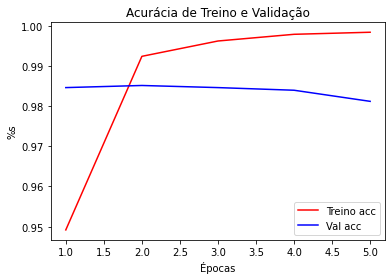

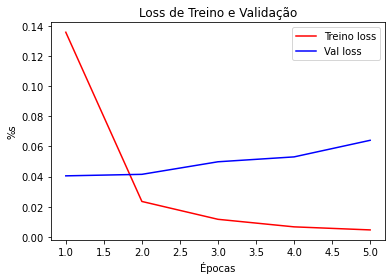

In [18]:
avaliacao(results)

# Desempenho com o teste

In [19]:
# Carregando o melhor modelo
model = load_model("modelo.keras")

In [20]:
# Aplicando os dados de teste no modelo e verificando sua performace 
test_loss, test_acc = model.evaluate(test_padded,y_test)
print(f"Test accuracy: {test_acc:.3f}")

594/594 [==============================] - 1s 2ms/step - loss: 0.0434 - accuracy: 0.9846
Test accuracy: 0.985


# Conclusão

O modelo de rede neural apresentou um ótimo desempenho com uma acuracia de 98,5% de acerto. Provando que é possível extrair analise de sentimento através dos dados, porém é necessário entender qual é o contexto em que o modelo será aplicado, uma vez que a escrita e o linguajar são diferentes a pesar de ser uma só lingua, uma analise no contexto do Tweeter requer um preprocessameno muito difente de uma analise no contexto jurídico por exemplo.